In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(file_path, sheet_name):
    """
    Load the raw data from an Excel file.
    """
    return pd.read_excel(file_path, sheet_name=sheet_name)

def drop_unnecessary_columns(df, columns):
    """
    Drop unnecessary columns from the DataFrame.
    """
    return df.drop(columns=columns)

def replace_not_available(df):
    """
    Replace "Not Available" entries with NaN, which can be interpreted as floating point numbers.
    """
    return df.replace({'Not Available': np.nan})

def convert_columns_to_numeric(df):
    """
    Convert columns that clearly contain numerical values to float type.
    """
    for col in df.columns:
        if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in col 
            or 'therms' in col or 'gal' in col or 'Score' in col):
            df[col] = df[col].astype(float)
    return df

def replace_negative_values(df, features):
    """
    Replace negative values in specified columns with NaN.
    """
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].apply(lambda x: np.nan if x < 0 else x)
    return df

def missing_values(df):
    """
    Calculate and print missing values per column.
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

def rename_columns(df):
    """
    Rename specific columns for clarity.
    """
    df.rename(columns={
        'Total GHG Emissions (Metric Tons CO2e)': 'GHG Emissions',
        'Direct GHG Emissions (Metric Tons CO2e)': 'Direct GHG Emissions',
        'Indirect GHG Emissions (Metric Tons CO2e)': 'Indirect GHG Emissions'
    }, inplace=True)
    return df

def plot_ghg_distribution(df):
    """
    Plot a histogram of GHG Emissions.
    """
    plt.figure(figsize=(10, 6))  
    plt.hist(df['GHG Emissions'].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of GHG Emissions (Metric Tons CO2e)')  
    plt.xlabel('GHG Emissions (Metric Tons CO2e)')  
    plt.ylabel('Frequency')  
    plt.grid(axis='y', alpha=0.75) 
    plt.show()

def plot_log_ghg_distribution(df):
    """
    Plot a histogram of log-transformed GHG Emissions.
    """
    plt.figure(figsize=(10, 6))  
    plt.hist(np.log1p(df['GHG Emissions'].dropna()), bins=30, color='blue', alpha=0.7)  
    plt.title('Log-Transformed Distribution of GHG Emissions (Metric Tons CO2e)')  
    plt.xlabel('Log(GHG Emissions + 1) (Metric Tons CO2e)')  
    plt.ylabel('Frequency')  
    plt.grid(axis='y', alpha=0.75)  
    plt.show()


In [7]:
columns_to_plot = [
    'Site EUI (kBtu/ft²)',
    'Weather Normalized Site EUI (kBtu/ft²)',
    'Weather Normalized Site Electricity Intensity (kWh/ft²)',
    'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
    'Water Use (All Water Sources) (kgal)',
    'Water Intensity (All Water Sources) (gal/ft²)',
    'GHG Emissions',
    'Direct GHG Emissions',
    'Indirect GHG Emissions'
]

def outliers_processing(df, columns):
    """
    Identify and remove outliers based on the IQR method.
    """
    outlier_indices = []  # Index to store outliers
    for col in columns_to_plot:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outliers)
    
    # Drop outliers and reset index
    df_clean = df.drop(outlier_indices).reset_index(drop=True)
    return df_clean, outlier_indices

In [4]:
def plot_correlation_matrix(df):
    numeric_data = df.select_dtypes(include=[float, int])
    corr_matrix = numeric_data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

def plot_pairplot(df):
    plot_data = df[[
        'Primary Property Use Type - Gross Floor Area (ft²)', 
        'Site EUI (kBtu/ft²)', 
        'Weather Normalized Site EUI (kBtu/ft²)', 
        'Weather Normalized Site Electricity Intensity (kWh/ft²)', 
        'Weather Normalized Site Natural Gas Intensity (therms/ft²)', 
        'Water Use (All Water Sources) (kgal)', 
        'Water Intensity (All Water Sources) (gal/ft²)',
        'GHG Emissions'
    ]]
    plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan}).dropna()
    plot_data.rename(columns={
        'Primary Property Use Type - Gross Floor Area (ft²)': 'Gross Floor Area',
        'Site EUI (kBtu/ft²)': 'Site EUI',
        'Weather Normalized Site EUI (kBtu/ft²)': 'Weather Norm EUI',
        'Weather Normalized Site Electricity Intensity (kWh/ft²)': 'Weather Norm Electricity Intensity',
        'Weather Normalized Site Natural Gas Intensity (therms/ft²)': 'Weather Norm Gas Intensity',
        'Water Use (All Water Sources) (kgal)': 'Water Use',
        'Water Intensity (All Water Sources) (gal/ft²)': 'Water Intensity'
    }, inplace=True)

    def corr_func(x, y, **kwargs):
        r = np.corrcoef(x, y)[0][1]
        ax = plt.gca()
        ax.annotate(f"r = {r:.2f}", xy=(0.2, 0.8), xycoords=ax.transAxes, size=14, color='black')
    
    pair = sns.pairplot(plot_data, diag_kind='kde', kind='scatter', palette='coolwarm', 
                        vars=['Gross Floor Area', 'Site EUI', 'Weather Norm EUI', 
                              'Weather Norm Electricity Intensity', 'Weather Norm Gas Intensity', 
                              'Water Use', 'Water Intensity', 'GHG Emissions'])
    pair.map_lower(corr_func)
    plt.suptitle('Pairplot of Key Variables and log GHG Emissions', size=18, y=1.02)
    plt.show()

def plot_density_by_building_type(df):
    Alltypes_num = df['Primary Property Type - Self Selected'].value_counts()
    building_types = list(Alltypes_num[Alltypes_num.values > 90].index)
    df['log_GHG_Emissions'] = np.log1p(df['GHG Emissions'])
    plt.figure(figsize=(10, 6))
    for b_type in building_types:
        subset = df[df['Largest Property Use Type'] == b_type]
        sns.kdeplot(subset['log_GHG_Emissions'].dropna(), label=b_type, shade=False, alpha=0.8)
    plt.xlabel('Log of GHG Emissions (Metric Tons CO2e)')
    plt.ylabel('Density')
    plt.title('Density Plot of Log-Transformed GHG Emissions by Building Type')
    plt.legend(title='Building Type')
    plt.show()

def create_age_group(df):
    current_year = 2024
    df['age'] = current_year - df['Year Built']
    df['age_group'] = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 100], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '>50'])
    age_emission = df.groupby('age_group')['GHG Emissions'].mean().reset_index()
    plt.figure(figsize=(8, 6))
    sns.heatmap(age_emission.pivot_table(index='age_group', values='GHG Emissions'), annot=True, cmap="coolwarm")
    plt.title('Heatmap: Building Age vs GHG Emissions', size=16)
    plt.ylabel('Building Age Group')
    plt.show()

def plot_box_by_building_count(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Number of Buildings - Self-reported', y='GHG Emissions', data=df)
    plt.xlabel('Number of Buildings - Self-reported', size=14)
    plt.ylabel('GHG Emissions (Metric Tons CO2e)', size=14)
    plt.title('Boxplot: Number of Buildings vs GHG Emissions', size=16)
    plt.show()

def plot_box_by_occupancy(df):
    df['Occupancy_group'] = pd.cut(df['Occupancy'], bins=[0, 25, 50, 75, 100], labels=['0-25%', '26-50%', '51-75%', '76-100%'])
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Occupancy_group', y='GHG Emissions', data=df)
    plt.xlabel('Occupancy (%)', size=14)
    plt.ylabel('GHG Emissions (Metric Tons CO2e)', size=14)
    plt.title('Boxplot: Occupancy vs GHG Emissions', size=16)
    plt.show()

Your selected dataframe has 21 columns.
There are 15 columns that have missing values.
                                                    Missing Values  \
Water Use (All Water Sources) (kgal)                          3984   
Water Intensity (All Water Sources) (gal/ft²)                 3984   
Latitude                                                      2263   
Longitude                                                     2263   
Weather Normalized Site Natural Gas Intensity (...            1963   
Weather Normalized Site EUI (kBtu/ft²)                        1465   
Weather Normalized Site Electricity Intensity (...             787   
Site EUI (kBtu/ft²)                                            163   
Street Number                                                  124   
Street Name                                                    122   
Direct GHG Emissions (Metric Tons CO2e)                         83   
Total GHG Emissions (Metric Tons CO2e)                          74   
Ind

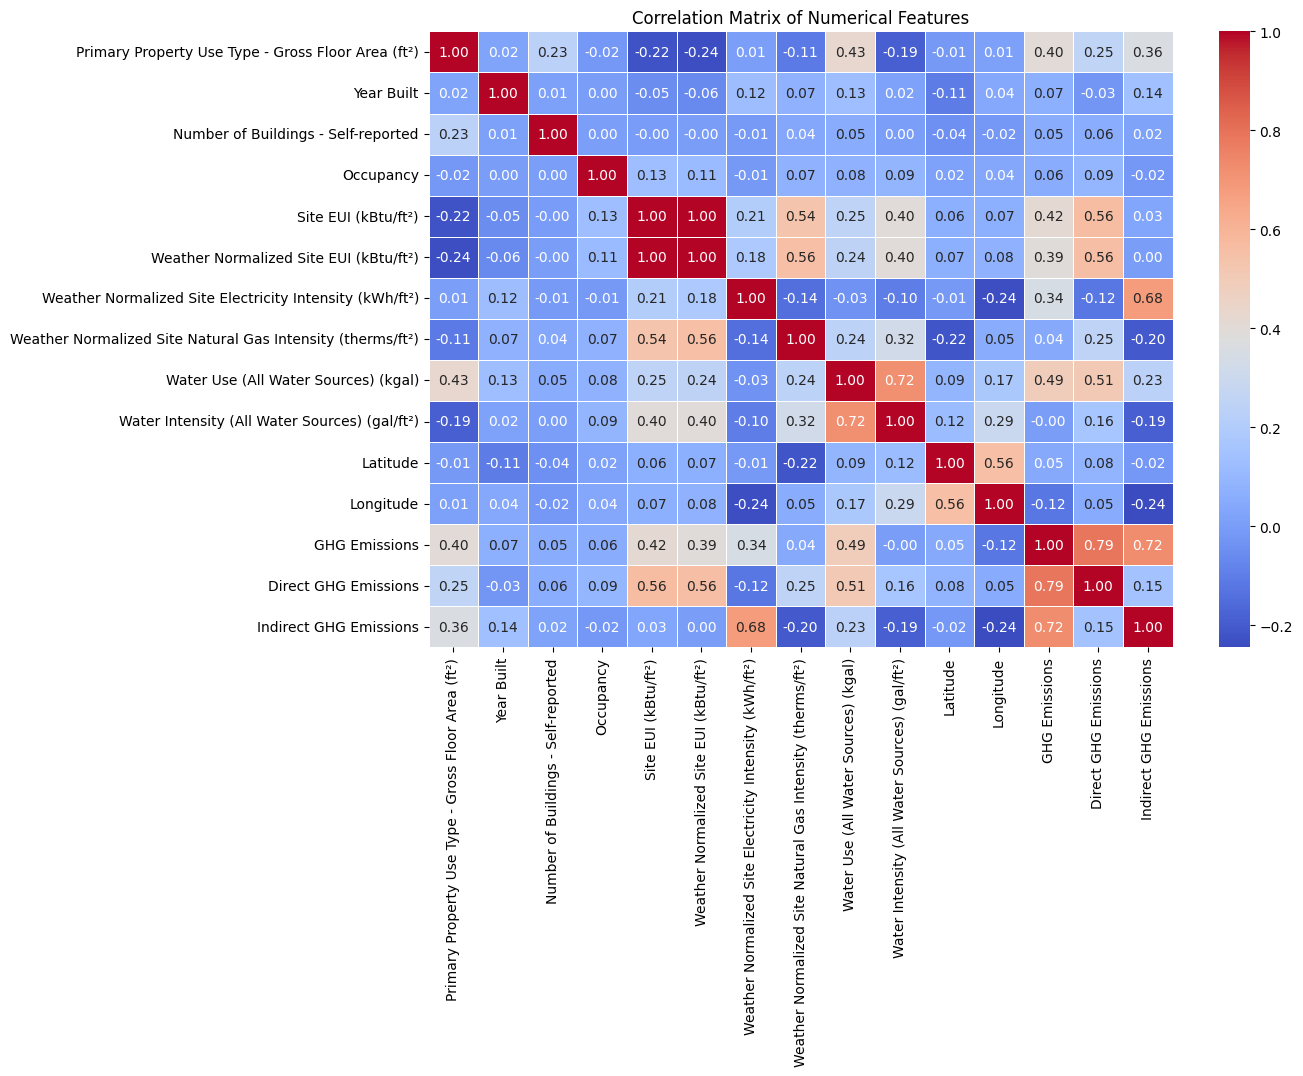

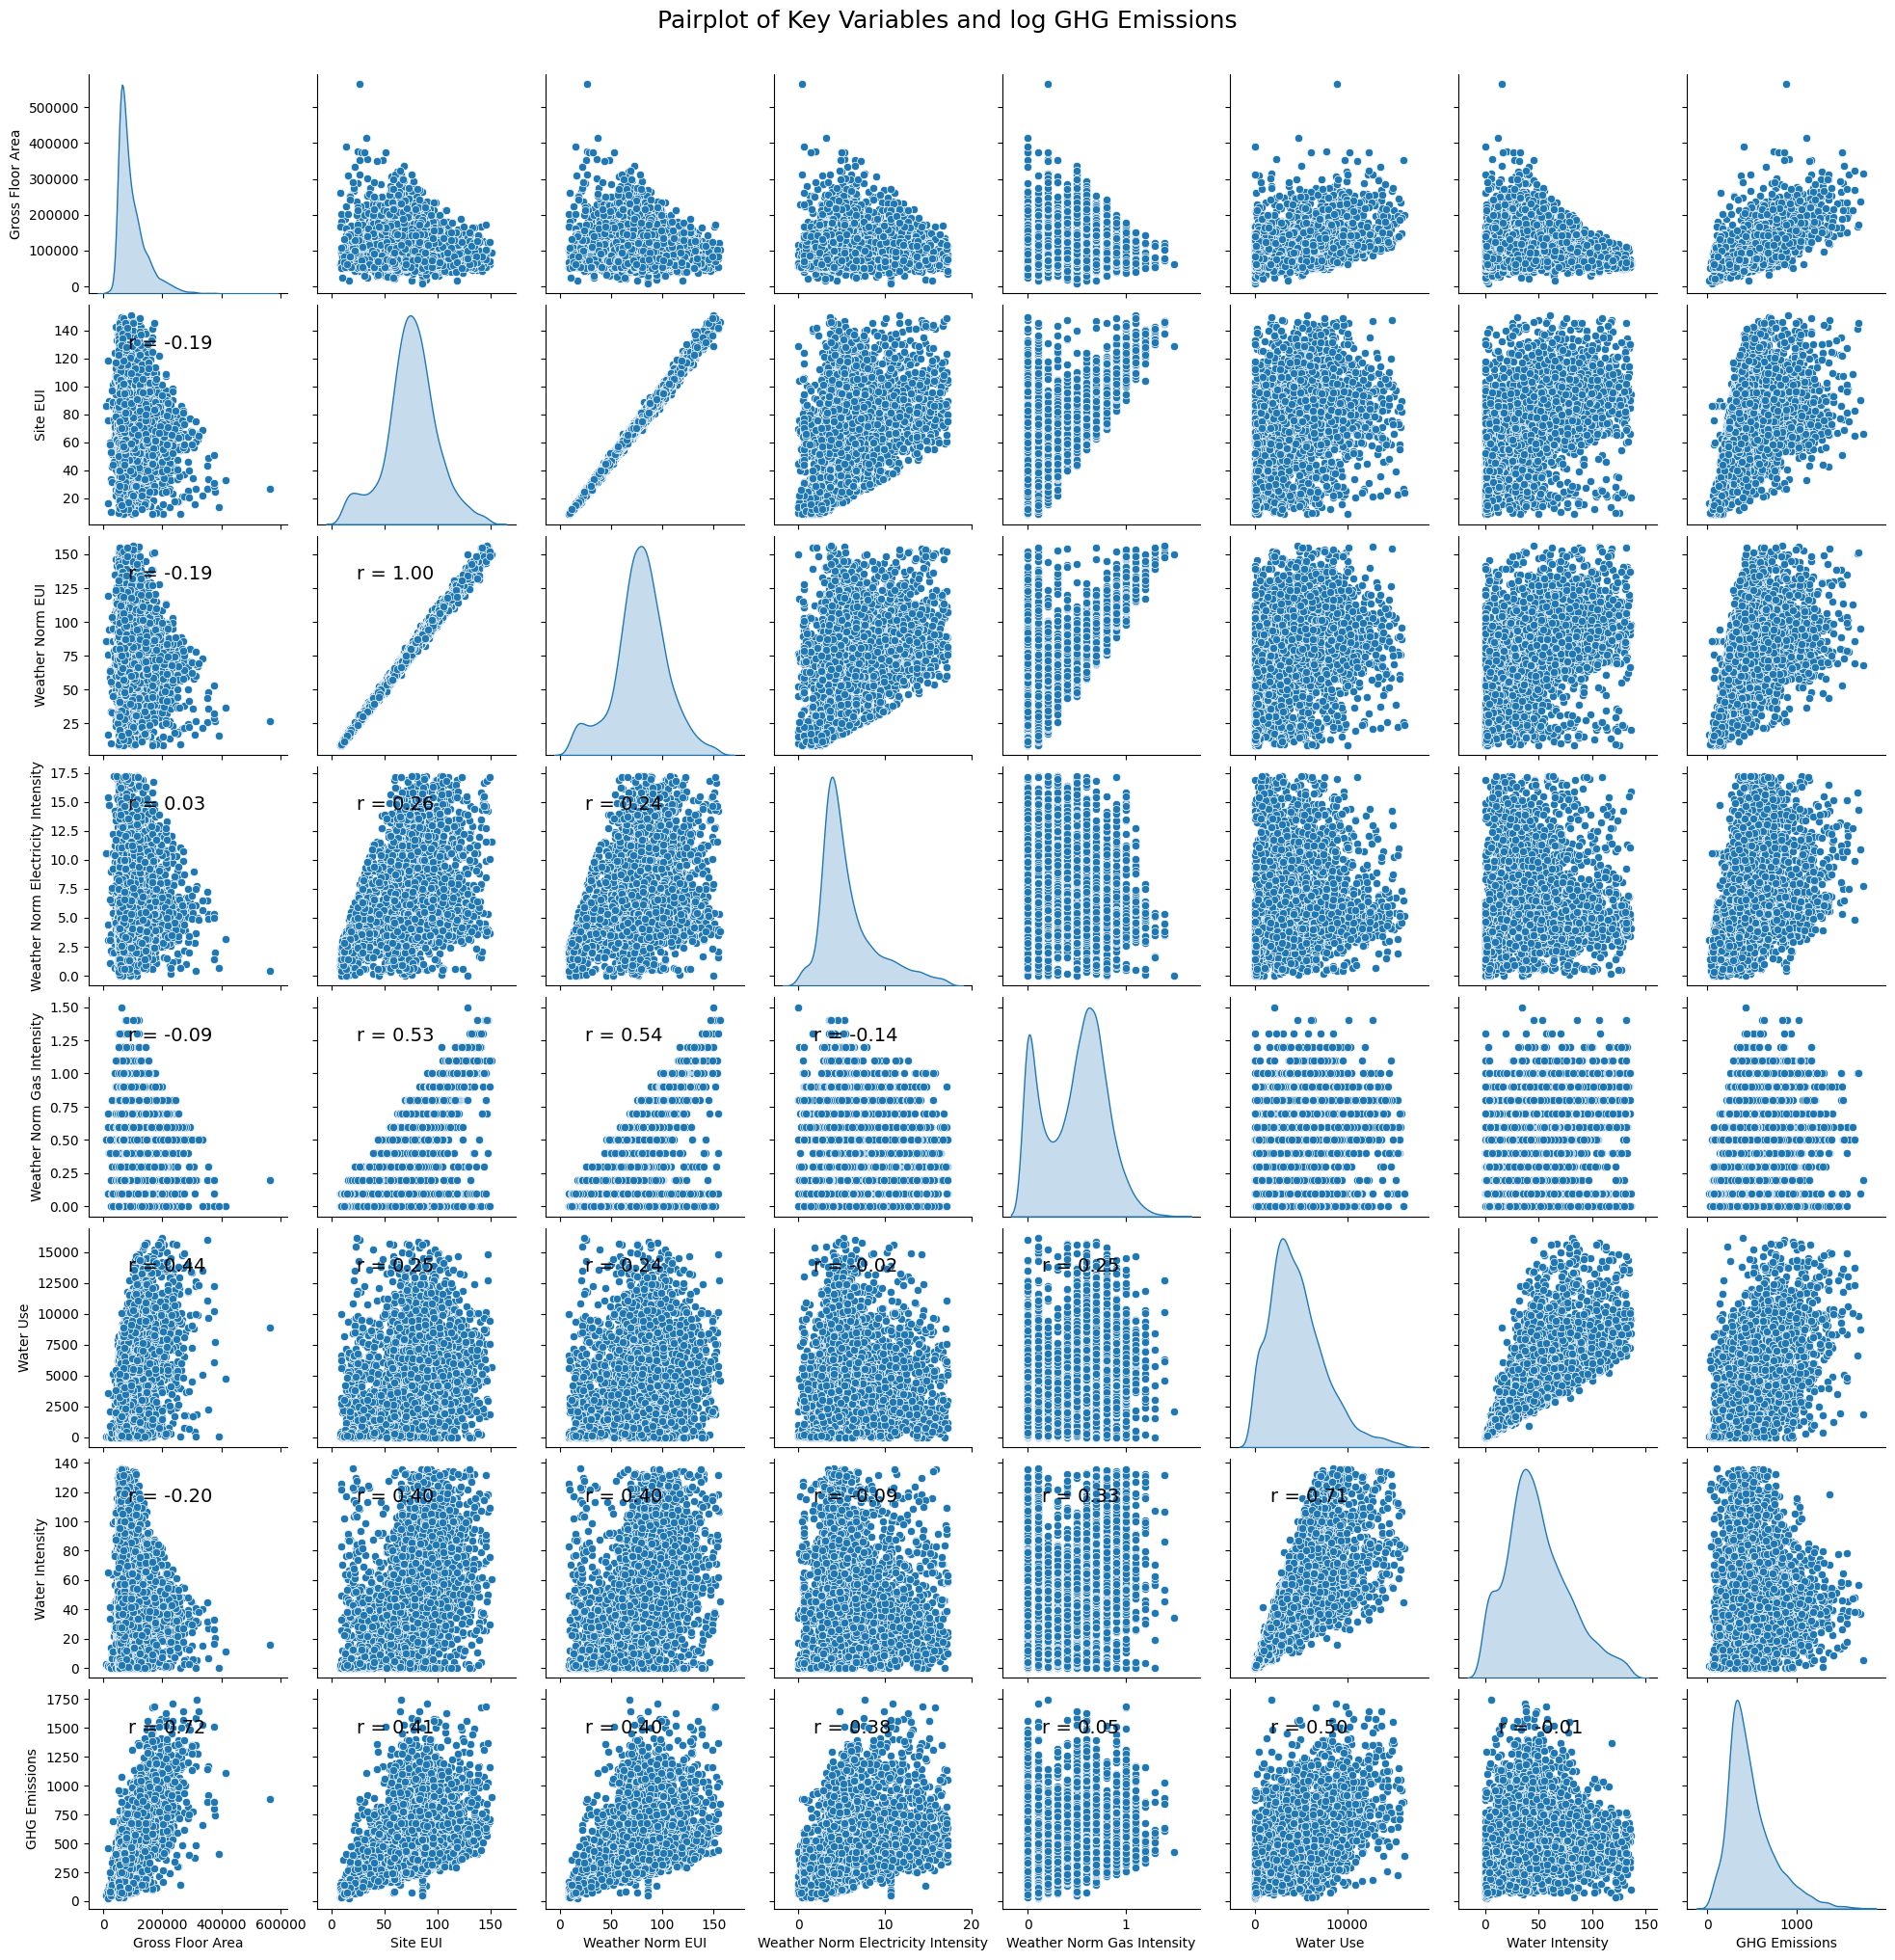

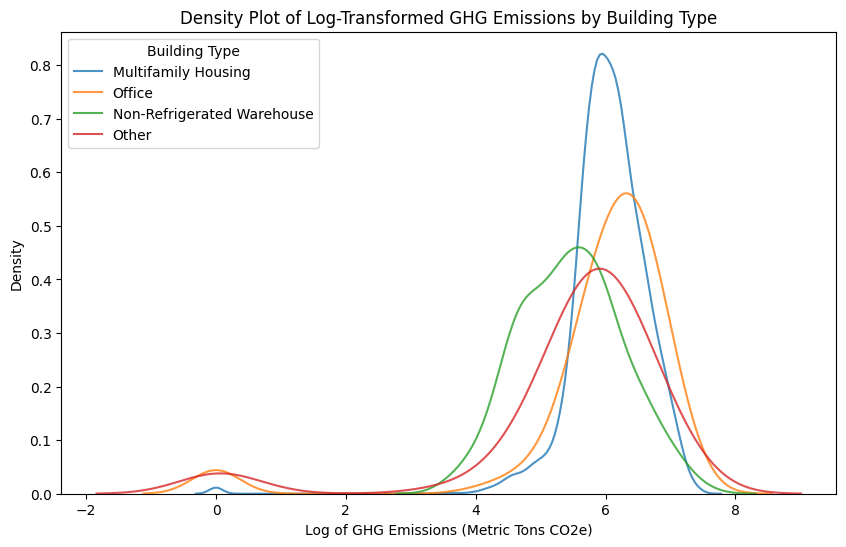

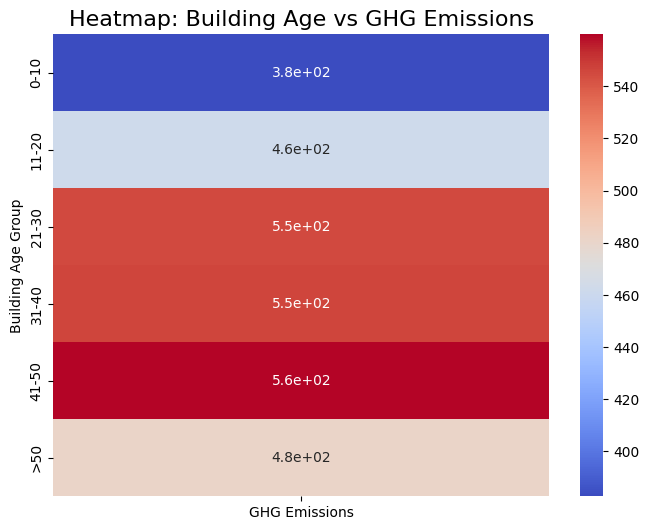

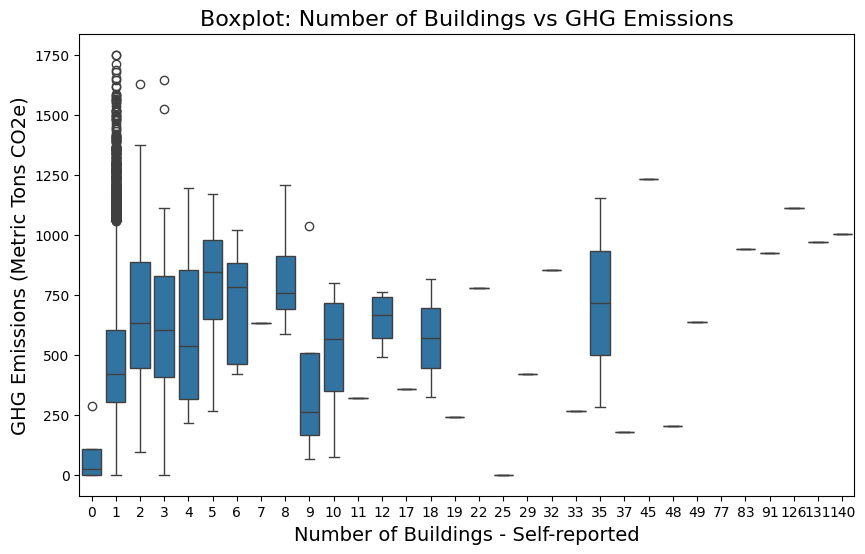

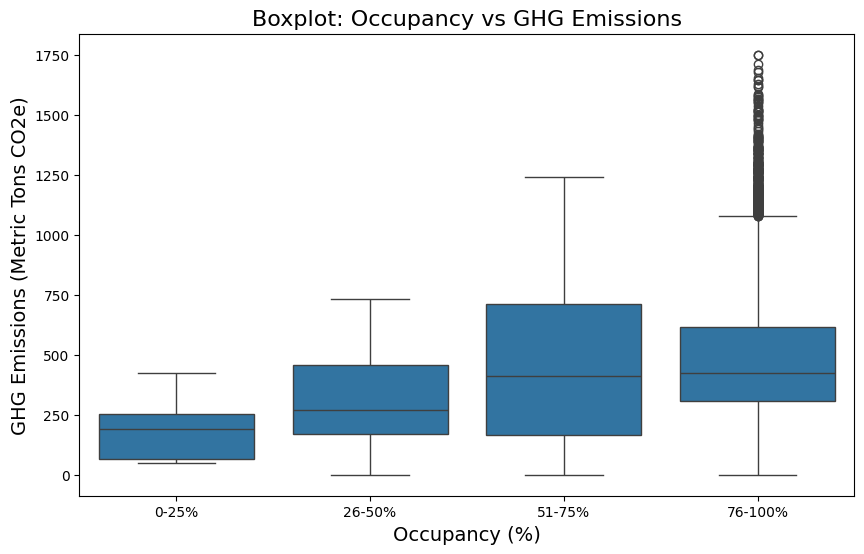

In [8]:
def main():
    file_path = "/Users/miemiell/Desktop/5105/data/raw_data.xlsx"
    sheet_name = 0
    
    data = load_data(file_path, sheet_name)
    
    # Drop unnecessary columns
    columns_to_drop = ["Order", "Property Id", "Parent Property Id", "BBL - 10 digits"]
    data = drop_unnecessary_columns(data, columns_to_drop)
    # Replace "Not Available" entries with NaN
    data = replace_not_available(data)
    # Convert appropriate columns to numeric types
    data = convert_columns_to_numeric(data)
    # Replace negative values with NaN
    non_negative_features = [
        'Water Use (All Water Sources) (kgal)',
        'Water Intensity (All Water Sources) (gal/ft²)',
        'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
        'Weather Normalized Site EUI (kBtu/ft²)',
        'Weather Normalized Site Electricity Intensity (kWh/ft²)',
        'Site EUI (kBtu/ft²)',
        'Total GHG Emissions (Metric Tons CO2e)',
        'Direct GHG Emissions (Metric Tons CO2e)',
        'Indirect GHG Emissions (Metric Tons CO2e)',
        'Primary Property Use Type - Gross Floor Area (ft²)',
        'Number of Buildings - Self-reported',
        'Occupancy',
    ]
    data = replace_negative_values(data, non_negative_features)
    # Process missing values
    missing_values_table = missing_values(data)
    print(missing_values_table)
    #Rename specific columns for clarity
    data = rename_columns(data)
    # Process outliers
    data_clean, outliers = outliers_processing(data, columns_to_plot)
    
    plot_correlation_matrix(data_clean)
    plot_pairplot(data_clean)
    plot_density_by_building_type(data_clean)
    create_age_group(data_clean)
    plot_box_by_building_count(data_clean)
    plot_box_by_occupancy(data_clean)
    
if __name__ == "__main__":
    main()
